In [1]:
import os
import cv2
import numpy as np
import random
from glob import glob
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'blod_cell'
BG_DIR = os.path.join(DATA_DIR, 'background')
CELL_DIR = os.path.join(DATA_DIR, 'cells')
IMG_SIZE = (480, 640)  # высота, ширина
MIN_CELLS = 5
MAX_CELLS = 25
NUM_IMAGES = 5

In [3]:
bg_paths = sorted(glob(os.path.join(BG_DIR, '*')))
cell_paths = sorted(glob(os.path.join(CELL_DIR, '*')))
print(f'Найдено {len(bg_paths)} фонов и {len(cell_paths)} клеток')

Найдено 7 фонов и 5 клеток


In [4]:
def get_random_bg():
    return cv2.imread(random.choice(bg_paths))

def get_random_cell(alpha=False):
    flags = cv2.IMREAD_UNCHANGED if alpha else cv2.IMREAD_COLOR
    return cv2.imread(random.choice(cell_paths), flags)

def place_cell(bg, cell, coord, alpha_lvl):
    h, w = cell.shape[:2]
    if cell.shape[-1] == 4:
        # альфа-канал
        alpha = (cell[:, :, 3] / 255.0) * alpha_lvl
        for c in range(3):
            bg[coord[0]:coord[0]+h, coord[1]:coord[1]+w, c] = (
                bg[coord[0]:coord[0]+h, coord[1]:coord[1]+w, c] * (1 - alpha) +
                cell[:, :, c] * alpha
            )
    else:
        blended = cv2.addWeighted(bg[coord[0]:coord[0]+h, coord[1]:coord[1]+w],
                                   1-alpha_lvl, cell, alpha_lvl, 0)
        bg[coord[0]:coord[0]+h, coord[1]:coord[1]+w] = blended
    return bg

def add_noise(img, amount=5):
    # процент шумных пикселей
    mask = np.random.rand(*img.shape[:2]) < (amount/100)
    noise = np.random.randint(0, 256, img.shape, dtype=np.uint8)
    img[mask] = noise[mask]
    return img

In [5]:
def generate_image():
    bg = cv2.resize(get_random_bg(), (IMG_SIZE[1], IMG_SIZE[0]))
    n_cells = random.randint(MIN_CELLS, MAX_CELLS)
    for _ in range(n_cells):
        cell = get_random_cell(alpha=True)
        cell = cv2.resize(cell, (64, 64))
        y = random.randint(0, IMG_SIZE[0] - 64)
        x = random.randint(0, IMG_SIZE[1] - 64)
        alpha_lvl = random.uniform(0.6, 1.0)
        bg = place_cell(bg, cell, (y, x), alpha_lvl)
    bg = add_noise(bg, amount=random.uniform(1, 5))
    return bg, n_cells

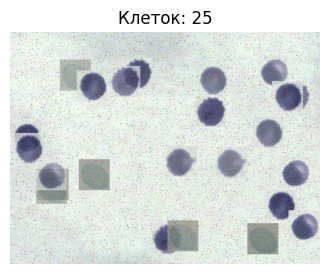

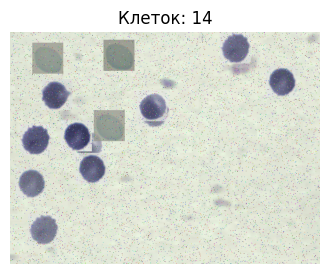

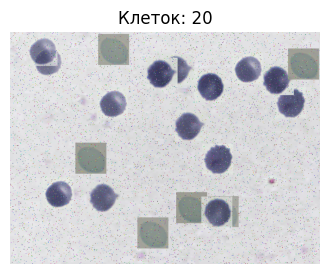

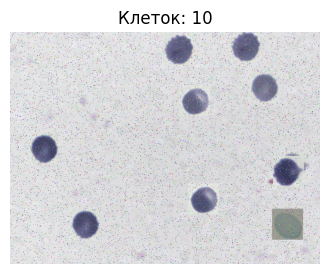

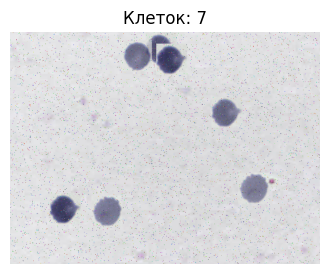

In [6]:
out_dir = 'generated'
os.makedirs(out_dir, exist_ok=True)
for i in range(NUM_IMAGES):
    img, count = generate_image()
    path = os.path.join(out_dir, f'synth_{i}_count{count}.png')
    cv2.imwrite(path, img)
    # показать результат
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Клеток: {count}')
    plt.axis('off')
    plt.show()